In [1]:
import torch
from torch import nn
import numpy as np
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Dataset

In [2]:
import torchvision

img_size = 32
num_classes = 10

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_images = torchvision.datasets.MNIST(root='mnist_data', train=True, 
                                    download=True, transform=transform)

In [4]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
dataloader = DataLoader(mnist_images, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model

In [5]:
channels = 1
img_shape = (channels, img_size, img_size)
latent_dim = 100

In [6]:
class Generator(nn.Module):
    def __init__(self, num_classes, emb_dim):
        super().__init__()
        self.init_size = 8
        self.label_emb = nn.Embedding(num_classes, emb_dim) 
        self.fc = nn.Linear(latent_dim+emb_dim, 128*8*8)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, padding=1),

            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),

            nn.BatchNorm2d(64,),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 
                      kernel_size=3, padding=1),            
            nn.Tanh()
        )
        
    def forward(self, z, label):
        cond = self.label_emb(label)
        x = torch.cat([z, cond], 1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(x)
        return img

In [7]:
class Descriminator(nn.Module):
    def __init__(self, num_classes, emb_dim):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, emb_dim) 
        
        self.injection = nn.Sequential(
            nn.Linear(channels*img_size*img_size + emb_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, channels*img_size*img_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.adv_layer = nn.Sequential(
            nn.Linear(128*2*2, 1), 
            nn.Sigmoid()
        )
        
    def forward(self, img, label):

        img_plat = img.view(img.size(0), -1)
        cond = self.label_emb(label)

        x = torch.cat([img_plat, cond], 1)
        x = self.injection(x)

        img = x.view(-1, 1, 32, 32)

        img = self.model(img)
        img = img.view(img.size(0), -1)
        
        validity = self.adv_layer(img)

        return validity

In [8]:
generator = Generator(num_classes=num_classes, emb_dim=32)
discriminator = Descriminator(num_classes=num_classes, emb_dim=32)

In [11]:
generator.to(device)


Generator(
  (label_emb): Embedding(10, 32)
  (fc): Linear(in_features=132, out_features=8192, bias=True)
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [12]:
discriminator.to(device)


Descriminator(
  (label_emb): Embedding(10, 32)
  (proj): Sequential(
    (0): Linear(in_features=1056, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# 3. Training

In [13]:
import os
os.makedirs("images_cDCGAN", exist_ok=True)

save_interval = 10

In [14]:
EPOCHS = 200

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

hist = {
        "train_G_loss": [],
        "train_D_loss": [],
}

In [15]:
for epoch in range(EPOCHS):
    running_G_loss = 0.0
    running_D_loss = 0.0

    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        condition_labels = torch.randint(0, num_classes, (imgs.shape[0],)).to(device)
        real_labels = torch.ones((imgs.shape[0], 1)).to(device)
        fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)


        # -------------------------- Train Generator --- 
        optimizer_G.zero_grad()
        
        # Noise input for Generator
        z = torch.randn((imgs.shape[0], latent_dim)).to(device)

        gen_imgs = generator(z, condition_labels)
        validity = discriminator(gen_imgs, condition_labels)
        G_loss = criterion(validity, real_labels)
        running_G_loss += G_loss.item()

        G_loss.backward()
        optimizer_G.step()


        # -------------- Train Discriminator --- 
        optimizer_D.zero_grad()

        real_validity = discriminator(real_imgs, labels)
        real_loss = criterion(real_validity, real_labels)

        fake_validity = discriminator(gen_imgs.detach(), condition_labels)
        fake_loss = criterion(fake_validity, fake_labels)
        
        D_loss = (real_loss + fake_loss) / 2
        running_D_loss += D_loss.item()

        D_loss.backward()
        optimizer_D.step()
    
    epoch_G_loss = running_G_loss / len(dataloader)
    epoch_D_loss = running_D_loss / len(dataloader)
    
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}")

    hist["train_G_loss"].append(epoch_G_loss)
    hist["train_D_loss"].append(epoch_D_loss)

    if epoch % save_interval == 0:
        save_image(gen_imgs.data[:25], f"images_cDCGAN/epoch_{epoch}.png", nrow=5, normalize=True)

Epoch [1/200], Train G Loss: 1.0543, Train D Loss: 0.6048
Epoch [2/200], Train G Loss: 1.1039, Train D Loss: 0.5754
Epoch [3/200], Train G Loss: 0.9966, Train D Loss: 0.5931
Epoch [4/200], Train G Loss: 1.1233, Train D Loss: 0.5498
Epoch [5/200], Train G Loss: 1.0775, Train D Loss: 0.5590
Epoch [6/200], Train G Loss: 1.2810, Train D Loss: 0.5042
Epoch [7/200], Train G Loss: 1.1912, Train D Loss: 0.5244
Epoch [8/200], Train G Loss: 1.1290, Train D Loss: 0.5459
Epoch [9/200], Train G Loss: 1.0858, Train D Loss: 0.5599
Epoch [10/200], Train G Loss: 1.0387, Train D Loss: 0.5748
Epoch [11/200], Train G Loss: 0.9918, Train D Loss: 0.5887
Epoch [12/200], Train G Loss: 0.9628, Train D Loss: 0.5995
Epoch [13/200], Train G Loss: 0.9243, Train D Loss: 0.6112
Epoch [14/200], Train G Loss: 0.9044, Train D Loss: 0.6177
Epoch [15/200], Train G Loss: 0.9143, Train D Loss: 0.6137
Epoch [16/200], Train G Loss: 0.8804, Train D Loss: 0.6241
Epoch [17/200], Train G Loss: 0.9014, Train D Loss: 0.6199
Epoch 

# 4. Inference

In [16]:
%matplotlib inline
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

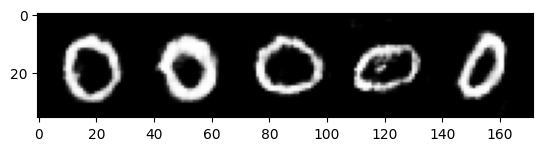

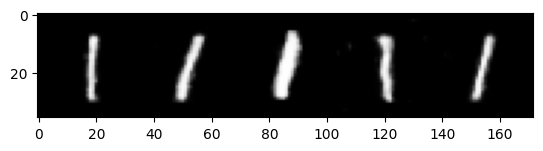

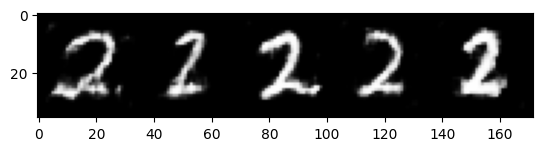

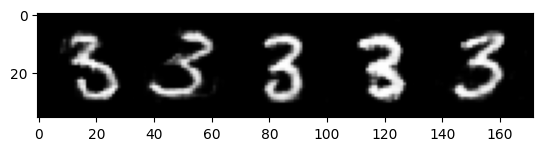

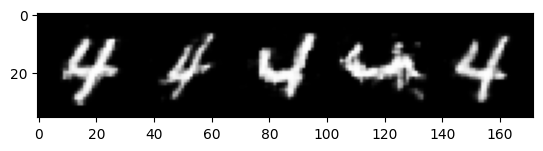

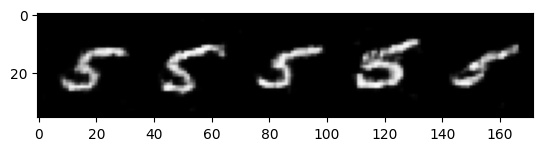

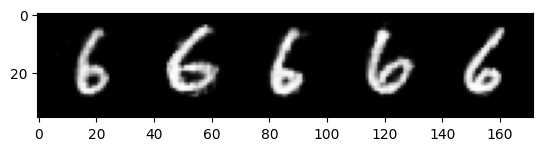

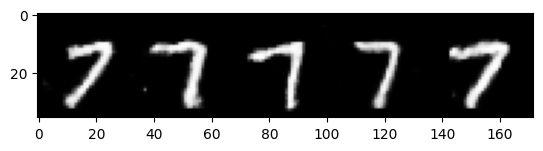

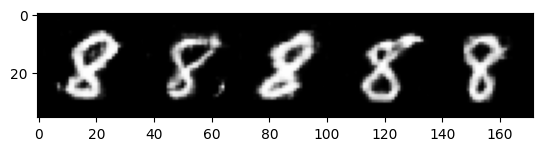

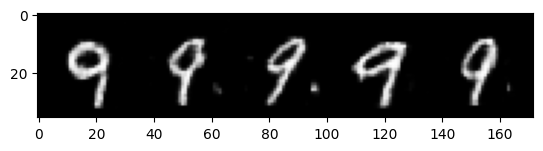

In [17]:
generator.eval()

num_sample = 5
for i in range(num_classes):
    target_class = i
    z = torch.randn((num_sample, latent_dim)).to(device)
    condition_labels = torch.full((num_sample,), target_class, dtype=torch.long).to(device)

    gen_imgs = generator(z, condition_labels).detach().cpu()

    grid = make_grid(gen_imgs, nrow=num_sample, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()